In [1]:
import os
import umap
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from Bio import SeqIO
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from qhoptim.pyt import QHM, QHAdam
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from scipy.stats import spearmanr, pearsonr
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: F

In [2]:
len("TTTCTGAGCATCCCGGGGATCCC")

23

In [3]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [4]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [5]:
DATAPATH = "/home/bakirillov/HDD/data/genomes/all_guides_chr22.tsv"
ANNOTATION = "/home/bakirillov/HDD/data/genomes/annotation.csv"

In [6]:
annotation = pd.read_csv(ANNOTATION, header=1)[["Start", "Stop", "Gene symbol"]]
annotation = list(
    zip(
        annotation["Start"].values, annotation["Stop"].values, 
        annotation["Gene symbol"].values
    )
)
annotation = sorted(annotation, key=lambda x: x[0])

In [7]:
transformer = get_Cas9_transformer(True)

In [8]:
chr22 = SeqIO.parse("/home/bakirillov/HDD/data/genomes/chr22.fa", "fasta")
chr22 = [a for a in chr22][0]

In [9]:
TEMPLATE = "/home/bakirillov/HDD/data/chr22_genes/GENE\nPERFECTMATCH\nNNNNNNNNNNNNNNNNNNNNNGG 6\n"
COMMAND = "/home/bakirillov/HDD/apps/cas-offinder CONFIG G OUTPUT"

In [10]:
%%bash

ls | grep xls

Cpf1_table.xlsx
ST3.xlsx
ST4 Chr22 top gRNAs per gene.xlsx
W_table.xlsx


In [11]:
d = pd.read_excel("ST4 Chr22 top gRNAs per gene.xlsx", sheet_name=0)

In [12]:
TOP10 = np.random.choice(d["4"].unique(), 100, replace=False)

In [17]:
script = open("run_casoffinder_ot.sh", "w")
script.write("#!/bin/sh\n\n")
for start, stop, gene in tqdm(annotation):
    with open("/home/bakirillov/HDD/data/chr22_genes_OT/"+gene+".fa", "w") as oh:
        oh.write(">"+gene+"\n")
        oh.write(str(chr22.seq[start:stop]))
    with open("/home/bakirillov/HDD/data/chr22_casoffinder_configs_OT/"+gene+".txt", "w") as oh:
        oh.write(TEMPLATE.replace("GENE", gene+".fa").split("\n")[0])
        oh.write("\nNNNNNNNNNNNNNNNNNNNNNGG\n")
        for a in TOP10:
            for b in range(1, 7):
                oh.write(a+" "+str(b)+"\n")
    script.write(
        COMMAND.replace(
            "CONFIG", "/home/bakirillov/HDD/data/chr22_casoffinder_configs_OT/"+gene+".txt"
        ).replace(
            "OUTPUT", "/home/bakirillov/HDD/data/chr22_grnas_OT/"+gene+".tsv"
        )+"\n"
    )
script.close()

100%|██████████| 1186/1186 [00:00<00:00, 2883.23it/s]


In [18]:
data = np.array(
    [a for a in os.walk("/home/bakirillov/HDD/data/chr22_grnas_OT/")][0][2]
)

In [19]:
sizes = np.array(
    [op.getsize(op.join("/home/bakirillov/HDD/data/chr22_grnas_OT", a)) for a in data]
)

In [20]:
u = ImperfectMatchTransform("NGG", False, False, fold=False, cut_at_start=0, cut_at_end=0)
transformer = transforms.Compose(
    [
        u, ToTensor(cudap=True)
    ]
)

In [21]:
w_encoder = GuideHN2d(
    23, capsule_dimension=32, n_routes=1600, n_classes=5, n_channels=2,
).cuda()
w_model = DKL(w_encoder, [1,5*32]).cuda().eval()
w_model.load_state_dict(torch.load("../models/Weissman/cnn59.ptch"))
w_model = w_model.eval()

In [22]:
genes = {a[2]: [] for a in annotation}
for i,a in enumerate(data):
    #with open(op.join("/home/bakirillov/HDD/data/casoffinder_data/", a), "r"):
    try:
        current_df = pd.read_csv(
            op.join(
                "/home/bakirillov/HDD/data/chr22_grnas_OT/"+a
            ), sep="\t", header=None
        ).dropna()
        current_df = current_df[current_df[3].apply(lambda x: len(x) == 23 and " " not in x)]
        current_df[6] = [a]*current_df.shape[0]
        print(i, current_df.shape)
    except Exception as e:
        print(e)
    else:
        tds = WeissmanDataset(
            current_df, np.arange(current_df.shape[0]), transformer,
            genome_column=3, sgRNA_column=0,
            label_column=5
        )
        tld = DataLoader(tds, shuffle=False, batch_size=256)
        tb_w_oa = []
        tb_w_va = []
        tb_w_ra = []
        for transformed_batch, _ in tqdm(tld):
            tb_w_o = w_encoder(transformed_batch)[0].cpu().data.numpy()
            tb_w_ra.extend(tb_w_o)
            tb_w = w_model(transformed_batch)
            tb_w_o = w_model.likelihood(
                tb_w[0]
            ).mean.mean(0).cpu().data.numpy()
            tb_w_v = w_model.likelihood(
                tb_w[0]
            ).variance.mean(0).cpu().data.numpy()
            tb_w_oa.extend(tb_w_o)
            tb_w_va.extend(tb_w_v)
        current_df[7] = tb_w_oa
        current_df[8] = tb_w_va
        current_df = current_df.sort_values(by=7, ascending=False)
        current_df.to_csv(
            op.join(
                "/home/bakirillov/HDD/data/cas9_ot_ordered/"+a
            ), sep="\t", header=None
        )

  0%|          | 0/1 [00:00<?, ?it/s]

0 (19, 7)
1 (2, 7)
No columns to parse from file
3 (32, 7)
4 (2, 7)
5 (118, 7)


100%|██████████| 1/1 [00:00<00:00, 12.24it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/2 [00:00<?, ?it/s]

6 (6, 7)
7 (134, 7)
8 (276, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

9 (298, 7)
10 (23, 7)


100%|██████████| 1/1 [00:00<00:00, 40.02it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

11 (6, 7)
12 (13, 7)
13 (1, 7)
14 (18, 7)
15 (140, 7)
No columns to parse from file
17 (6, 7)


100%|██████████| 2/2 [00:00<00:00, 11.64it/s]

18 (4, 7)
19 (311, 7)
No columns to parse from file



100%|██████████| 1/1 [00:00<00:00, 40.83it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

21 (5, 7)
22 (28, 7)
23 (6, 7)
24 (12, 7)
25 (72, 7)
26 (2, 7)
27 (19, 7)
No columns to parse from file
29 (4, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

30 (268, 7)
31 (502, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

32 (23, 7)
33 (127, 7)
No columns to parse from file
35 (280, 7)


100%|██████████| 1/1 [00:00<00:00, 49.54it/s]

36 (39, 7)
37 (18, 7)
38 (18, 7)
39 (108, 7)
40 (14, 7)
No columns to parse from file
42 (5, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

43 (5, 7)
44 (4, 7)
45 (3, 7)
46 (58, 7)
47 (1, 7)
48 (30, 7)
49 (81, 7)


100%|██████████| 1/1 [00:00<00:00, 75.63it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

50 (45, 7)
No columns to parse from file
52 (2, 7)
53 (2, 7)
54 (6, 7)
No columns to parse from file
56 (28, 7)
57 (46, 7)
58 (1, 7)


100%|██████████| 1/1 [00:00<00:00, 87.65it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

59 (12, 7)
No columns to parse from file
No columns to parse from file
62 (81, 7)
63 (4, 7)
No columns to parse from file
65 (183, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

66 (3, 7)
67 (1, 7)
68 (5, 7)
69 (12, 7)
70 (37, 7)
71 (45, 7)
72 (3, 7)
73 (64, 7)


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]

74 (106, 7)
75 (102, 7)
76 (32, 7)
77 (4, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
79 (9, 7)
80 (66, 7)
81 (5, 7)
82 (9, 7)
83 (24, 7)
No columns to parse from file
85 (59, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

86 (1, 7)
87 (3, 7)
88 (15, 7)
89 (5, 7)
90 (74, 7)
91 (2, 7)
92 (51, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

93 (19, 7)
94 (63, 7)
No columns to parse from file
96 (7, 7)
97 (7, 7)
98 (26, 7)
99 (2, 7)
100 (9, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.43it/s]

No columns to parse from file
102 (53, 7)
103 (282, 7)


100%|██████████| 1/1 [00:00<00:00, 12.83it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

104 (137, 7)
105 (6, 7)
106 (101, 7)
No columns to parse from file
108 (46, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

109 (21, 7)
110 (51, 7)
No columns to parse from file
112 (9, 7)
113 (59, 7)
114 (5, 7)
115 (1, 7)
116 (2, 7)


100%|██████████| 1/1 [00:00<00:00, 70.76it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
 50%|█████     | 1/2 [00:00<00:00,  7.30it/s]

No columns to parse from file
No columns to parse from file
119 (6, 7)
120 (1, 7)
121 (490, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

No columns to parse from file
123 (100, 7)
124 (42, 7)
125 (3, 7)
126 (272, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

127 (60, 7)
128 (2, 7)
129 (107, 7)
130 (17, 7)
131 (25, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

132 (29, 7)
133 (1, 7)
134 (109, 7)
135 (530, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

136 (51, 7)
137 (158, 7)
138 (12, 7)
139 (3, 7)
No columns to parse from file
141 (39, 7)


100%|██████████| 1/1 [00:00<00:00, 70.32it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
100%|██████████| 1/1 [00:00<00:00, 69.72it/s]


No columns to parse from file
No columns to parse from file
144 (10, 7)
145 (4, 7)
No columns to parse from file
147 (6, 7)
No columns to parse from file
No columns to parse from file
150 (64, 7)
151 (10, 7)
152 (3, 7)
153 (6, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

154 (9, 7)
155 (36, 7)
156 (43, 7)
157 (79, 7)
158 (19, 7)
159 (205, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

160 (185, 7)
161 (16, 7)
No columns to parse from file
163 (14, 7)
164 (26, 7)
165 (10, 7)


100%|██████████| 1/1 [00:00<00:00, 22.24it/s]

166 (153, 7)
167 (18, 7)
168 (57, 7)



  0%|          | 0/4 [00:00<?, ?it/s]

169 (8, 7)
170 (11, 7)
171 (11, 7)
172 (831, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

173 (28, 7)
No columns to parse from file
175 (19, 7)
176 (138, 7)
177 (42, 7)
178 (8, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

179 (3, 7)
No columns to parse from file
181 (97, 7)
182 (43, 7)
No columns to parse from file
184 (90, 7)
185 (57, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

186 (249, 7)
187 (386, 7)


100%|██████████| 2/2 [00:00<00:00,  9.82it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/2 [00:00<?, ?it/s]

188 (6, 7)
189 (66, 7)
190 (11, 7)
191 (1, 7)
192 (29, 7)
193 (405, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

194 (48, 7)
195 (23, 7)
No columns to parse from file
197 (7, 7)
198 (13, 7)
199 (36, 7)
200 (11, 7)
201 (336, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.36it/s]

No columns to parse from file
No columns to parse from file
204 (801, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.30it/s]

205 (362, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
207 (263, 7)
208 (200, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

209 (12, 7)
No columns to parse from file
211 (25, 7)
212 (10, 7)
213 (8, 7)
No columns to parse from file
215 (12, 7)
216 (6, 7)
No columns to parse from file
218 (369, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.86it/s]

219 (9, 7)
220 (382, 7)


100%|██████████| 1/1 [00:00<00:00, 74.48it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
 50%|█████     | 1/2 [00:00<00:00,  7.74it/s]

221 (5, 7)
No columns to parse from file
223 (6, 7)
224 (330, 7)


100%|██████████| 2/2 [00:00<00:00, 12.96it/s]

225 (38, 7)
No columns to parse from file
227 (279, 7)
228 (51, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
230 (12, 7)
231 (8, 7)
232 (131, 7)
No columns to parse from file
234 (228, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

235 (10, 7)
236 (185, 7)
No columns to parse from file
No columns to parse from file
239 (4, 7)
No columns to parse from file
241 (190, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
243 (24, 7)
244 (59, 7)
No columns to parse from file
246 (4, 7)
247 (95, 7)
248 (7, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

249 (10, 7)
No columns to parse from file
251 (4, 7)
252 (57, 7)
253 (10, 7)
254 (6, 7)
No columns to parse from file
No columns to parse from file
257 (6, 7)
258 (611, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.55it/s]

259 (54, 7)
260 (292, 7)


100%|██████████| 1/1 [00:00<00:00, 52.80it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
262 (96, 7)
263 (2, 7)
No columns to parse from file
265 (23, 7)
266 (17, 7)
267 (6, 7)
No columns to parse from file
No columns to parse from file
270 (39, 7)


100%|██████████| 1/1 [00:00<00:00, 71.98it/s]

271 (31, 7)
272 (32, 7)
No columns to parse from file
274 (4, 7)
275 (48, 7)
No columns to parse from file
277 (42, 7)
278 (1, 7)



 25%|██▌       | 1/4 [00:00<00:00,  7.11it/s]

279 (797, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

280 (13, 7)
281 (50, 7)
282 (21, 7)
283 (5, 7)
284 (3, 7)
285 (3, 7)
286 (129, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

287 (5, 7)
No columns to parse from file
289 (10, 7)
No columns to parse from file
No columns to parse from file
No columns to parse from file
293 (8, 7)
No columns to parse from file
295 (8, 7)
No columns to parse from file
297 (247, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

298 (83, 7)
299 (13, 7)
300 (104, 7)
301 (532, 7)


100%|██████████| 1/1 [00:00<00:00, 32.58it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
100%|██████████| 1/1 [00:00<00:00, 37.56it/s]

302 (1, 7)
No columns to parse from file
304 (42, 7)
305 (6, 7)
306 (1, 7)
307 (3, 7)
308 (1, 7)
309 (2, 7)
No columns to parse from file
311 (16, 7)
No columns to parse from file



  0%|          | 0/1 [00:00<?, ?it/s]

313 (20, 7)
314 (17, 7)
315 (205, 7)
316 (8, 7)


100%|██████████| 1/1 [00:00<00:00, 85.97it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

317 (59, 7)
318 (3, 7)
No columns to parse from file
320 (157, 7)
321 (1, 7)
322 (6, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

323 (58, 7)
324 (4, 7)
325 (65, 7)
326 (109, 7)
327 (2, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

328 (251, 7)
No columns to parse from file
330 (1, 7)
331 (1, 7)
No columns to parse from file
333 (127, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

No columns to parse from file
335 (210, 7)
336 (1098, 7)


100%|██████████| 1/1 [00:00<00:00, 16.15it/s]

337 (25, 7)
338 (5, 7)
No columns to parse from file
No columns to parse from file
341 (20, 7)
342 (5, 7)
343 (6, 7)
No columns to parse from file
345 (106, 7)



100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

346 (2, 7)
347 (3, 7)
348 (102, 7)
349 (30, 7)
350 (2, 7)
351 (25, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

352 (1, 7)
353 (44, 7)
354 (214, 7)
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
359 (8, 7)


100%|██████████| 1/1 [00:00<00:00, 46.73it/s]


360 (293, 7)
No columns to parse from file
362 (19, 7)
363 (63, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

364 (16, 7)
365 (203, 7)
No columns to parse from file
No columns to parse from file
368 (8, 7)
369 (270, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.88it/s]

370 (90, 7)
371 (421, 7)


100%|██████████| 1/1 [00:00<00:00, 24.82it/s]


372 (118, 7)
373 (77, 7)
374 (3, 7)
No columns to parse from file
376 (62, 7)
377 (710, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

378 (126, 7)
379 (3, 7)
380 (52, 7)
381 (502, 7)


100%|██████████| 1/1 [00:00<00:00, 59.07it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

382 (3, 7)
383 (7, 7)
384 (87, 7)
385 (3, 7)
No columns to parse from file
387 (1, 7)
388 (12, 7)
389 (6, 7)
No columns to parse from file
No columns to parse from file
No columns to parse from file
393 (34, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

394 (4, 7)
395 (20, 7)
No columns to parse from file
397 (1, 7)
No columns to parse from file
399 (165, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.75it/s]

400 (676, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
402 (132, 7)
403 (19, 7)
404 (1, 7)
405 (5, 7)
No columns to parse from file
407 (3, 7)
408 (35, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

409 (99, 7)
410 (56, 7)
411 (17, 7)
No columns to parse from file
413 (9, 7)
414 (1, 7)
415 (20, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

416 (2, 7)
417 (1, 7)
418 (54, 7)
419 (11, 7)
No columns to parse from file
No columns to parse from file
422 (266, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

423 (6, 7)
424 (23, 7)
425 (30, 7)
No columns to parse from file
427 (24, 7)
428 (4, 7)
429 (51, 7)
No columns to parse from file
431 (231, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

432 (87, 7)
433 (140, 7)
434 (212, 7)


100%|██████████| 1/1 [00:00<00:00, 66.28it/s]


435 (163, 7)
436 (3, 7)
437 (38, 7)
438 (1, 7)
439 (7, 7)
No columns to parse from file
No columns to parse from file
No columns to parse from file
443 (4, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

444 (18, 7)
No columns to parse from file
446 (39, 7)
447 (22, 7)
No columns to parse from file
449 (245, 7)


100%|██████████| 1/1 [00:00<00:00, 38.39it/s]

450 (7, 7)
451 (22, 7)
452 (17, 7)
453 (70, 7)
No columns to parse from file
455 (26, 7)
456 (28, 7)
No columns to parse from file
No columns to parse from file



  0%|          | 0/2 [00:00<?, ?it/s]

459 (1, 7)
460 (281, 7)
461 (11, 7)
462 (370, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
464 (15, 7)
465 (140, 7)
466 (18, 7)
467 (29, 7)
No columns to parse from file
No columns to parse from file
470 (27, 7)


100%|██████████| 1/1 [00:00<00:00, 27.44it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

471 (35, 7)
472 (20, 7)
473 (52, 7)
474 (6, 7)
475 (18, 7)
476 (11, 7)
No columns to parse from file
No columns to parse from file
479 (48, 7)


100%|██████████| 1/1 [00:00<00:00, 27.55it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
481 (6, 7)
482 (39, 7)
483 (183, 7)
484 (7, 7)
485 (50, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

486 (86, 7)
No columns to parse from file
488 (228, 7)
489 (88, 7)


100%|██████████| 1/1 [00:00<00:00, 78.08it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

490 (10, 7)
491 (2, 7)
492 (6, 7)
493 (13, 7)
494 (1, 7)
495 (2, 7)
No columns to parse from file
497 (2, 7)
No columns to parse from file
499 (29, 7)
500 (25, 7)


100%|██████████| 1/1 [00:00<00:00, 31.45it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

501 (109, 7)
502 (42, 7)
No columns to parse from file
No columns to parse from file
No columns to parse from file
506 (6, 7)
507 (117, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

508 (50, 7)
509 (25, 7)
No columns to parse from file
511 (193, 7)
512 (3, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

513 (22, 7)
514 (94, 7)
515 (6, 7)
516 (78, 7)
517 (1028, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

518 (255, 7)
519 (145, 7)


100%|██████████| 1/1 [00:00<00:00, 48.98it/s]


No columns to parse from file
521 (15, 7)
522 (5, 7)
523 (52, 7)
524 (1, 7)
No columns to parse from file
526 (15, 7)
527 (2, 7)
528 (17, 7)
529 (182, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

No columns to parse from file
531 (6, 7)
532 (1, 7)
533 (10, 7)
No columns to parse from file
535 (4, 7)
536 (8, 7)
No columns to parse from file
538 (64, 7)
539 (384, 7)


100%|██████████| 1/1 [00:00<00:00, 70.77it/s]

No columns to parse from file
No columns to parse from file
542 (3, 7)
543 (1, 7)
No columns to parse from file
545 (1, 7)
No columns to parse from file
No columns to parse from file
548 (5, 7)
549 (6, 7)
550 (21, 7)
551 (6, 7)
552 (5, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

553 (11, 7)
No columns to parse from file
555 (8, 7)
556 (17, 7)
557 (35, 7)
558 (68, 7)
559 (7, 7)
560 (23, 7)


 12%|█▎        | 1/8 [00:00<00:00,  7.33it/s]

No columns to parse from file
562 (1, 7)
563 (1814, 7)


100%|██████████| 1/1 [00:00<00:00, 28.13it/s]

564 (20, 7)
565 (14, 7)
No columns to parse from file
567 (171, 7)
568 (50, 7)



 33%|███▎      | 1/3 [00:00<00:00,  7.36it/s]

569 (587, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

570 (206, 7)
571 (27, 7)
572 (333, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

573 (63, 7)
574 (58, 7)
575 (3, 7)
No columns to parse from file
577 (73, 7)
578 (146, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

No columns to parse from file
580 (3, 7)
581 (76, 7)
582 (2, 7)
583 (2, 7)
584 (7, 7)
585 (28, 7)
No columns to parse from file
587 (276, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

588 (3, 7)
589 (94, 7)
590 (230, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

591 (174, 7)
592 (1660, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

593 (141, 7)
594 (128, 7)
595 (2, 7)
596 (270, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

597 (1, 7)
598 (46, 7)
599 (15, 7)
600 (1, 7)
601 (3, 7)
602 (4, 7)
603 (3, 7)
604 (845, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

605 (3, 7)
No columns to parse from file
607 (50, 7)
608 (5, 7)
609 (21, 7)
610 (5, 7)
611 (60, 7)
No columns to parse from file
613 (5, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

614 (67, 7)
615 (16, 7)
No columns to parse from file
617 (8, 7)
No columns to parse from file
619 (3, 7)
620 (12, 7)
621 (85, 7)


100%|██████████| 1/1 [00:00<00:00, 69.53it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/2 [00:00<?, ?it/s]

No columns to parse from file
623 (11, 7)
624 (6, 7)
625 (6, 7)
626 (59, 7)
627 (409, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
629 (130, 7)
630 (94, 7)
631 (7, 7)
632 (11, 7)
633 (2, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

634 (106, 7)
635 (77, 7)
636 (81, 7)
637 (41, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.70it/s]

638 (2, 7)
639 (1, 7)
No columns to parse from file
No columns to parse from file
642 (733, 7)


100%|██████████| 1/1 [00:00<00:00, 61.44it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

643 (11, 7)
No columns to parse from file
645 (6, 7)
646 (4, 7)
647 (8, 7)
No columns to parse from file
649 (1, 7)
650 (1, 7)
651 (24, 7)
No columns to parse from file
653 (21, 7)
No columns to parse from file
655 (4, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

656 (31, 7)
No columns to parse from file
658 (6, 7)
No columns to parse from file
660 (38, 7)
No columns to parse from file
662 (25, 7)
663 (24, 7)
664 (69, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

665 (55, 7)
666 (4, 7)
667 (91, 7)
668 (247, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

No columns to parse from file
670 (104, 7)
671 (35, 7)
672 (435, 7)


100%|██████████| 2/2 [00:00<00:00, 10.23it/s]

673 (354, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

674 (92, 7)
675 (133, 7)
676 (80, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

677 (34, 7)
678 (207, 7)
No columns to parse from file
680 (90, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

681 (54, 7)
682 (37, 7)
683 (18, 7)
684 (2, 7)
685 (34, 7)
686 (173, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

687 (142, 7)
688 (28, 7)
689 (10, 7)
No columns to parse from file
691 (32, 7)
692 (32, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

693 (10, 7)
694 (17, 7)
695 (1, 7)
696 (2, 7)
No columns to parse from file
698 (193, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

699 (14, 7)
No columns to parse from file
No columns to parse from file
No columns to parse from file
703 (5, 7)
No columns to parse from file
705 (28, 7)
706 (34, 7)
707 (583, 7)


100%|██████████| 1/1 [00:00<00:00, 11.16it/s]

No columns to parse from file
709 (20, 7)
No columns to parse from file
711 (13, 7)
No columns to parse from file
713 (8, 7)
714 (2, 7)
No columns to parse from file
716 (167, 7)



  0%|          | 0/2 [00:00<?, ?it/s]

717 (6, 7)
718 (62, 7)
719 (9, 7)
720 (5, 7)
721 (299, 7)


100%|██████████| 2/2 [00:00<00:00, 12.32it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
100%|██████████| 1/1 [00:00<00:00, 37.28it/s]

722 (6, 7)
723 (7, 7)
724 (2, 7)
725 (29, 7)
726 (4, 7)
727 (38, 7)
728 (34, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

729 (50, 7)
730 (13, 7)
731 (70, 7)
732 (144, 7)


100%|██████████| 1/1 [00:00<00:00, 61.63it/s]

733 (27, 7)
734 (92, 7)
No columns to parse from file
736 (32, 7)
737 (7, 7)
738 (1, 7)
739 (10, 7)
No columns to parse from file
741 (3, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
No columns to parse from file
744 (3, 7)
745 (253, 7)
746 (11, 7)
747 (1, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

748 (107, 7)
749 (5, 7)
750 (17, 7)
751 (19, 7)
752 (30, 7)
753 (120, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

754 (88, 7)
No columns to parse from file
No columns to parse from file
No columns to parse from file
758 (30, 7)
No columns to parse from file
No columns to parse from file
No columns to parse from file
762 (11, 7)
763 (71, 7)
764 (1, 7)
765 (1, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

766 (63, 7)
767 (65, 7)
768 (40, 7)
769 (5, 7)
770 (174, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

771 (136, 7)
772 (372, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

773 (3, 7)
774 (7, 7)
775 (12, 7)
No columns to parse from file
777 (42, 7)
No columns to parse from file
No columns to parse from file
780 (10, 7)
No columns to parse from file
782 (4, 7)
783 (116, 7)


100%|██████████| 1/1 [00:00<00:00, 14.82it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

784 (6, 7)
785 (2, 7)
786 (66, 7)
787 (58, 7)
788 (36, 7)
789 (36, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

790 (81, 7)
No columns to parse from file
No columns to parse from file
793 (33, 7)
794 (31, 7)
795 (19, 7)
796 (3, 7)
797 (11, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

798 (87, 7)
799 (2, 7)
800 (16, 7)
801 (41, 7)
802 (23, 7)
803 (121, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

804 (35, 7)
No columns to parse from file
806 (79, 7)
807 (4, 7)
808 (499, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
810 (58, 7)
811 (89, 7)
812 (2, 7)
813 (59, 7)
814 (76, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

815 (6, 7)
816 (15, 7)
817 (1, 7)
No columns to parse from file
No columns to parse from file
820 (1, 7)
821 (3, 7)
822 (74, 7)
823 (10, 7)
824 (44, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.86it/s]

825 (3, 7)
No columns to parse from file
827 (1, 7)
828 (468, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

829 (55, 7)
830 (227, 7)
831 (131, 7)


100%|██████████| 1/1 [00:00<00:00, 81.65it/s]


No columns to parse from file
833 (29, 7)
834 (40, 7)
835 (5, 7)
836 (10, 7)
837 (23, 7)
838 (11, 7)
839 (2, 7)
840

  0%|          | 0/1 [00:00<?, ?it/s]

 (20, 7)
841 (10, 7)
842 (86, 7)
843 (195, 7)
844 (30, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

845 (26, 7)
846 (144, 7)
847 (15, 7)
848 (47, 7)
849 (69, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

850 (31, 7)
851 (2, 7)
852 (2, 7)
853 (6, 7)
854 (8, 7)
855 (8, 7)
856 (252, 7)


100%|██████████| 1/1 [00:00<00:00, 74.07it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

857 (118, 7)
858 (2, 7)
859 (5, 7)
860 (6, 7)
861 (12, 7)
862 (6, 7)
863 (11, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.66it/s]

864 (430, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
866 (65, 7)
No columns to parse from file
868 (5, 7)
869 (206, 7)
No columns to parse from file
871 (18, 7)


100%|██████████| 1/1 [00:00<00:00, 69.64it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
100%|██████████| 1/1 [00:00<00:00, 52.29it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

872 (7, 7)
873 (6, 7)
874 (17, 7)
875 (6, 7)
876 (1, 7)
877 (2, 7)
878 (7, 7)
879 (21, 7)
880 (29, 7)


100%|██████████| 1/1 [00:00<00:00, 77.67it/s]

881 (13, 7)
No columns to parse from file
883 (3, 7)
884 (32, 7)
885 (75, 7)
No columns to parse from file
No columns to parse from file
888 (42, 7)
889 (4, 7)



100%|██████████| 1/1 [00:00<00:00, 64.09it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

890 (4, 7)
891 (6, 7)
892 (26, 7)
893 (1, 7)
894 (101, 7)
No columns to parse from file
896 (4, 7)
897 (48, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

898 (4, 7)
899 (48, 7)
900 (49, 7)
901 (23, 7)
902 (47, 7)
No columns to parse from file
904 (37, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
No columns to parse from file
907 (100, 7)
908 (3, 7)
909 (28, 7)
910 (23, 7)
911 (55, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

912 (31, 7)
913 (81, 7)
914 (129, 7)
915 (4, 7)
916 (109, 7)


100%|██████████| 1/1 [00:00<00:00, 58.26it/s]

917 (16, 7)
918 (2, 7)
919 (2, 7)
920 (12, 7)
921 (7, 7)
No columns to parse from file
923 (22, 7)
924 (16, 7)
No columns to parse from file
926 (12, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

927 (7, 7)
928 (44, 7)
929 (2, 7)
No columns to parse from file
931 (103, 7)
No columns to parse from file
933 (18, 7)
934 (34, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

935 (13, 7)
936 (13, 7)
937 (46, 7)
938 (26, 7)
No columns to parse from file
940 (2, 7)
No columns to parse from file
942 (1, 7)
943 (18, 7)
944 (360, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

945 (36, 7)
946 (92, 7)
947 (2, 7)
No columns to parse from file
949 (146, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

950 (27, 7)
951 (4, 7)
952 (10, 7)
953 (7, 7)
954 (22, 7)
955 (256, 7)


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/2 [00:00<?, ?it/s]

956 (6, 7)
957 (13, 7)
958 (10, 7)
959 (79, 7)
960 (55, 7)
961 (301, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

962 (63, 7)
963 (23, 7)
964 (47, 7)
965 (54, 7)
966 (10, 7)
No columns to parse from file
968 (189, 7)


100%|██████████| 1/1 [00:00<00:00, 69.07it/s]


969 (7, 7)
970 (25, 7)
971 (108, 7)
972 (2, 7)
973 (16, 7)
974 (7, 7)
975 (67, 7)


100%|██████████| 1/1 [00:00<00:00, 38.49it/s]

976 (4, 7)
977 (60, 7)
978 (174, 7)
No columns to parse from file
980 (31, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
982 (4, 7)
983 (26, 7)
984 (15, 7)
No columns to parse from file
No columns to parse from file
987 (2, 7)
988 (4, 7)
989 (115, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

990 (11, 7)
991 (2, 7)
992 (11, 7)
993 (32, 7)
No columns to parse from file
995 (120, 7)
996 (59, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
998 (18, 7)
999 (2, 7)
1000 (233, 7)
1001 (16, 7)


100%|██████████| 1/1 [00:00<00:00, 91.24it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

1002 (43, 7)
1003 (1, 7)
1004 (6, 7)
1005 (5, 7)
1006 (116, 7)
No columns to parse from file
No columns to parse from file
1009 (234, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1010 (9, 7)
1011 (42, 7)
1012 (140, 7)
1013 (5, 7)
1014 (52, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1015 (75, 7)
1016 (1, 7)
1017 (21, 7)
1018 (228, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
1020 (44, 7)
1021 (113, 7)
No columns to parse from file
1023 (6, 7)
1024 (37, 7)
No columns to parse from file
1026 (109, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1027 (85, 7)
1028 (11, 7)
1029 (93, 7)
1030 (18, 7)
1031 (744, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1032 (52, 7)
1033 (23, 7)
1034 (20, 7)
1035 (56, 7)
1036 (7, 7)
No columns to parse from file
1038 (5, 7)
No columns to parse from file
1040 (3, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
1042 (106, 7)
1043 (2, 7)
No columns to parse from file
No columns to parse from file
1046 (8, 7)
1047 (3, 7)
1048 (11, 7)
1049 (1, 7)
1050 (4, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1051 (141, 7)
No columns to parse from file
1053 (362, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1054 (9, 7)
1055 (41, 7)
1056 (104, 7)
1057 (4, 7)
1058 (1, 7)
No columns to parse from file
1060 (267, 7)


100%|██████████| 1/1 [00:00<00:00, 79.90it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/2 [00:00<?, ?it/s]

1061 (94, 7)
1062 (3, 7)
No columns to parse from file
1064 (6, 7)
1065 (35, 7)
1066 (273, 7)


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
100%|██████████| 1/1 [00:00<00:00, 74.06it/s]

1067 (64, 7)
1068 (245, 7)
1069 (6, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
1071 (4, 7)
No columns to parse from file
No columns to parse from file
1074 (12, 7)
1075 (2, 7)
1076 (98, 7)
No columns to parse from file
No columns to parse from file
1079 (5, 7)
No columns to parse from file
1081 (1, 7)
1082 (214, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1083 (106, 7)
1084 (47, 7)
1085 (1, 7)
No columns to parse from file
1087 (42, 7)
1088 (13, 7)
No columns to parse from file
1090 (238, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1091 (48, 7)
1092 (5, 7)
No columns to parse from file
1094 (33, 7)
1095 (230, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1096 (9, 7)
1097 (37, 7)
No columns to parse from file
1099 (9, 7)
1100 (270, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1101 (46, 7)
1102 (33, 7)
1103 (35, 7)
No columns to parse from file
1105 (7, 7)
No columns to parse from file
1107 (6, 7)
1108 (223, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1109 (2, 7)
No columns to parse from file
1111 (96, 7)
1112 (5, 7)
1113 (13, 7)
1114 (135, 7)


100%|██████████| 1/1 [00:00<00:00, 63.96it/s]


No columns to parse from file
1116 (15, 7)
1117 (2, 7)
1118 (17, 7)
1119 (49, 7)
1120 (9, 7)
1121 (1, 7)
1122 (9, 7)
No columns to parse from file
1124 (2, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1125 (4, 7)
1126 (1, 7)
1127 (54, 7)
1128 (493, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1129 (47, 7)
1130 (51, 7)
1131 (20, 7)
1132 (20, 7)
1133 (166, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1134 (3, 7)
1135 (93, 7)
1136 (258, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1137 (3, 7)
1138 (7, 7)
1139 (7, 7)
1140 (15, 7)
1141 (4, 7)
1142 (14, 7)
1143 (114, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1144 (3, 7)
1145 (11, 7)
1146 (30, 7)
1147 (297, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1148 (209, 7)
1149 (83, 7)
1150 (568, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.80it/s]

1151 (9, 7)
1152 (718, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1153 (20, 7)
1154 (24, 7)
No columns to parse from file
No columns to parse from file
1157 (1, 7)
1158 (62, 7)
1159 (7, 7)
1160 (93, 7)


100%|██████████| 2/2 [00:00<00:00, 10.10it/s]

1161 (372, 7)



100%|██████████| 1/1 [00:00<00:00, 68.21it/s]

1162 (13, 7)
No columns to parse from file
1164 (15, 7)
1165 (5, 7)
No columns to parse from file
1167 (39, 7)
1168 (25, 7)
No columns to parse from file
1170 (25, 7)
1171 (6, 7)



100%|██████████| 1/1 [00:00<00:00, 71.78it/s]

1172 (1, 7)
No columns to parse from file
1174 (69, 7)
No columns to parse from file
No columns to parse from file
1177 (126, 7)
1178 (7, 7)
1179 (4, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

1180 (327, 7)
1181 (4, 7)


100%|██████████| 1/1 [00:00<00:00, 81.18it/s]

No columns to parse from file
1183 (1, 7)
1184 (69, 7)
1185 (3, 7)


In [23]:
ordered_data = [a for a in os.walk("/home/bakirillov/HDD/data/cas9_ot_ordered/")][0][2]

In [24]:
total = None
nothing = []
for i,a in enumerate(ordered_data):
    print(i,a)
    try:
        current_df = pd.read_csv(
            op.join(
                "/home/bakirillov/HDD/data/cas9_ot_ordered/"+a
            ), sep="\t", header=None
        )
    except:
        nothing.append(a)
        print(i,a, "nothing")
    else:
        if i == 0:
            total = current_df
        else:
            total = total.append(current_df)

0 SERPIND1.tsv
1 HSFY1P1.tsv
2 SLC25A15P5.tsv
3 LOC339685.tsv
4 GTSE1-DT.tsv
5 TPTEP2.tsv
6 RNU6-1219P.tsv
7 SAMM50.tsv
8 PLA2G6.tsv
9 XPNPEP3.tsv
10 LOC105373007.tsv
11 RPL34P35.tsv
12 APOBEC3A.tsv
13 LINC00896.tsv
14 CHKB.tsv
15 TMEM184B.tsv
16 MIR4763.tsv
17 DGCR6.tsv
18 LOC105372860.tsv
19 SEZ6L.tsv
20 RPL32P5.tsv
21 CA15P1.tsv
22 LINC00634.tsv
23 MIR6069.tsv
24 CRELD2.tsv
25 HSCB.tsv
26 LOC101232810.tsv
27 APOBEC3C.tsv
28 RPL15P22.tsv
29 LOC730668.tsv
30 CACNA1I.tsv
31 MEI1.tsv
32 LOC107985568.tsv
33 HIC2.tsv
34 CRIP1P4.tsv
35 MYH9.tsv
36 RASD2.tsv
37 IGLV2-14.tsv
38 LOC101927447.tsv
39 TOM1.tsv
40 LOC105373067.tsv
41 RNA5SP493.tsv
42 VN1R9P.tsv
43 LOC105373015.tsv
44 GGTLC2.tsv
45 LOC105373018.tsv
46 CDC45.tsv
47 ANP32BP2.tsv
48 RTN4R.tsv
49 SHANK3.tsv
50 SULT4A1.tsv
51 ZNF73P.tsv
52 KRT18P5.tsv
53 RPL8P5.tsv
54 LINC01639.tsv
55 TPTEP1.tsv
56 LOC101927474.tsv
57 SREBF2-AS1.tsv
58 SEC14L2.tsv
59 RPS19BP1.tsv
60 PI4KAP2.tsv
61 FBXW4P1.tsv
62 LINC01659.tsv
63 TMEM191C.tsv
64 BCRP7.t

515 GTPBP1.tsv
516 MRPL40.tsv
517 LINC01656.tsv
518 RN7SL280P.tsv
519 LOC105372947.tsv
520 LOC112268295.tsv
521 KIAA1671.tsv
522 RN7SL263P.tsv
523 LINC01310.tsv
524 LOC101927202.tsv
525 KLHDC7B-DT.tsv
526 LOC112268288.tsv
527 TIMP3.tsv
528 RPS15AP38.tsv
529 RN7SL757P.tsv
530 PARVG.tsv
531 IGLV2-23.tsv
532 LOC105373019.tsv
533 LOC100422416.tsv
534 LOC100129358.tsv
535 LOC105373069.tsv
536 IGLC2.tsv
537 LOC107985588.tsv
538 LMF2.tsv
539 RN7SL812P.tsv
540 PNPLA3.tsv
541 TPTEP2-CSNK1E.tsv
542 DESI1.tsv
543 POLDIP3.tsv
544 LOC100129254.tsv
545 CBX6.tsv
546 LOC112268294.tsv
547 MLC1.tsv
548 DENND6B.tsv
549 NDUFA6-DT.tsv
550 LINC01422.tsv
551 YDJC.tsv
552 SDF2L1.tsv
553 ACTR3BP6.tsv
554 MYO18B.tsv
555 LOC107987325.tsv
556 MIR5739.tsv
557 PPP1R26P2.tsv
558 LOC129026.tsv
559 LOC105373057.tsv
560 EIF4HP2.tsv
561 RRP7BP.tsv
562 IGKV1OR22-1.tsv
563 MYO18B-AS1.tsv
564 MCHR1.tsv
565 APOL6.tsv
566 IGLV3-10.tsv
567 GCAT.tsv
568 LOC105373037.tsv
569 MB.tsv
570 CCDC157.tsv
571 LOC110091768.tsv
572 TUBA3

1009 ASLP1.tsv
1010 C1QTNF6.tsv
1011 IGLV3-4.tsv
1012 LOC105372942.tsv
1013 LOC339666.tsv
1014 SOCS2P2.tsv
1015 KCTD17.tsv
1016 CCDC116.tsv
1017 SCO2.tsv
1018 SEC14L3.tsv
1019 LOC112267890.tsv
1020 FAM83F.tsv
1021 LOC112268296.tsv
1022 LOC101060852.tsv
1023 TTLL1.tsv
1024 LOC105373062.tsv
1025 H1-0.tsv
1026 CRYBA4.tsv
1027 RPL3.tsv


In [25]:
nothing

[]

In [26]:
total.to_csv("W_ot_paper_ready.tsv")

In [27]:
total

,0,1,2,3,4,5,6,7,8,9
0,18,CTGGGGCTCAGTAAACACAGTGG,SERPIND1,10260,tTGGGGCTgAaTtAACAgAGTGG,-,5,SERPIND1.tsv,0.146509,0.015744
1,17,CTGGGGCTCAGTAAACACAGTGG,SERPIND1,10260,tTGGGGCTgAaTtAACAgAGTGG,-,5,SERPIND1.tsv,0.146497,0.016037
2,10,CAGGAGAATCAGTTGAACCCGGG,SERPIND1,1601,CAGGAGgATCgcTTGAgCCCaGG,-,5,SERPIND1.tsv,0.146457,0.016275
3,14,CAGGAGAATCAGTTGAACCCGGG,SERPIND1,1601,CAGGAGgATCgcTTGAgCCCaGG,-,5,SERPIND1.tsv,0.146407,0.016008
4,3,CAGGACAACCACTTGAACCCGGG,SERPIND1,552,CAGGAgAAtCgCTTaAACCCGGG,+,4,SERPIND1.tsv,0.145452,0.012006
...,...,...,...,...,...,...,...,...,...,...
67,45,CCCCTGACCCCACCACACCGTGG,CRYBA4,3019,aCCCTGACCtCAgCACACacaGG,+,6,CRYBA4.tsv,0.113586,0.075177
68,68,AGAGCAAACCATGAACAAGGAGG,CRYBA4,8436,AGAGgAAACgAgctcCAAGGAGG,-,6,CRYBA4.tsv,0.111072,0.082156
0,2,TGTGGAGAGAAGGAAAGAGAGGG,RPL3,648,gGgaGAGgaAAGGAAgGAGAGGG,-,6,RPL3.tsv,0.395202,0.008788
1,1,AGCCACCCTGACCATCACTGGGG,RPL3,1741,AaCCcCaCTccCCATCACgGGGG,+,6,RPL3.tsv,0.136306,0.009416


In [28]:
from pylab import rcParams

rcParams["figure.figsize"] = (12,10)

In [29]:
m_bins, m_edges = np.histogram(total[8].values)
v_bins, v_edges = np.histogram(total[9].values)

In [30]:
m_edges

array([0.10363158, 0.14247603, 0.18132048, 0.22016493, 0.25900937,
       0.29785382, 0.33669827, 0.37554272, 0.41438717, 0.45323162,
       0.49207607])

In [31]:
v_edges

array([0.00872166, 0.02417965, 0.03963764, 0.05509563, 0.07055361,
       0.0860116 , 0.10146959, 0.11692758, 0.13238557, 0.14784355,
       0.16330154])

In [32]:
def bin_n(x, edges):
    if x <= edges[0]:
        return(1)
    elif x >= edges[-1]:
        return(edges.shape[0]-1)
    else:
        return((edges > x).tolist().index(True))

In [33]:
total[10] = total[8].apply(lambda x: bin_n(x, m_edges))
total[11] = total[9].apply(lambda x: bin_n(x, v_edges))

In [34]:
known_ots = pd.read_csv(
    "/home/bakirillov/HDD/data/Svetlana_data/Table_S8_machine_learning_input.txt", index_col=0, sep="\t"
)

In [35]:
def n_mms(a, b):
    return(np.sum([int(c != d) for c,d in zip(a, b)]))

In [36]:
only_those = [n_mms(a, b) > 0 for a,b in zip(known_ots["genome input"], known_ots["sgRNA input"])]

In [37]:
known_ots.shape

(26248, 10)

In [38]:
known_ots[only_those].shape

(26248, 10)

In [39]:
u2 = ImperfectMatchTransform("NGG", False, False, fold=False, cut_at_start=2, cut_at_end=1)
transformer2 = transforms.Compose(
    [
        u2, ToTensor(cudap=True)
    ]
)

In [40]:
ko_set = WeissmanDataset(known_ots, np.arange(known_ots.shape[0]), transformer2)
ko_set_loader = DataLoader(ko_set, shuffle=False, batch_size=256)

In [41]:
ko_w_oa = []
ko_w_va = []
for transformed_batch, _ in tqdm(ko_set_loader):
    ko_w = w_model(transformed_batch)
    ko_w_o = w_model.likelihood(
        ko_w[0]
    ).mean.mean(0).cpu().data.numpy()
    ko_w_v = w_model.likelihood(
        ko_w[0]
    ).variance.mean(0).cpu().data.numpy()
    ko_w_oa.extend(ko_w_o)
    ko_w_va.extend(ko_w_v)

100%|██████████| 103/103 [00:12<00:00,  8.37it/s]


In [42]:
len(ko_w_va)

26248

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


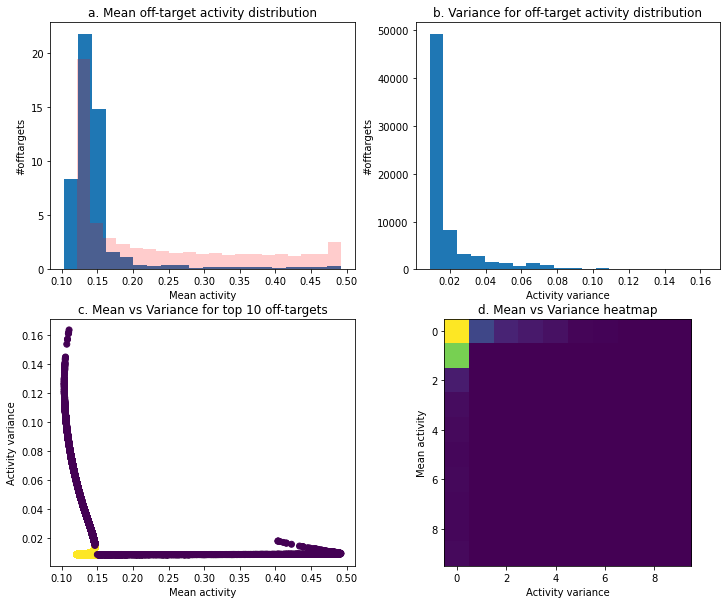

In [56]:
fig, ax = plt.subplots(2, 2)
#fig.suptitle('Off-targets for the best on-target gRNAs')
ax[0][0].hist(total[8].values, density=True, bins=20)
ax[0][0].hist(ko_w_oa, bins=20, density=True, color=(1,0,0,0.2))
ax[0][0].set_title("a. Mean off-target activity distribution")
ax[0][0].set_xlabel("Mean activity")
ax[0][0].set_ylabel("#offtargets")
ax[0][1].hist(total[9].values, bins=20)
#ax[0][1].hist(ko_w_va, bins=20, density=False, color=(1,0,0,0.2))
#ax[0][1].set_ylim((0,100))
ax[0][1].set_title("b. Variance for off-target activity distribution")
ax[0][1].set_xlabel("Activity variance")
ax[0][1].set_ylabel("#offtargets")
ax[1][0].scatter(total[8], total[9], c=np.logical_and(total[8] < 0.15, total[9] < 0.015))
ax[1][0].set_title("c. Mean vs Variance for top 10 off-targets")
ax[1][0].set_xlabel("Mean activity")
ax[1][0].set_ylabel("Activity variance")
ax[1][1].imshow(pd.crosstab(total[10], total[11]).values)
ax[1][1].set_title("d. Mean vs Variance heatmap")
ax[1][1].set_xlabel("Activity variance")
ax[1][1].set_ylabel("Mean activity")
fig.show()

In [48]:
np.arange(total.shape[0])[np.logical_and(total[8] < 0.15, total[9] < 0.015)].shape

(36926,)

In [64]:
total[[8,9]][np.logical_and(total[8] < 0.15, total[9] < 0.015)]

,8,9
4,0.145452,0.012006
5,0.145225,0.011772
6,0.145096,0.011720
7,0.143252,0.010751
8,0.142875,0.010619
...,...,...
61,0.121515,0.008753
62,0.121411,0.008757
63,0.121406,0.008750
64,0.121377,0.008761


In [66]:
np.mean(total[[8,9]][np.logical_and(total[8] < 0.15, total[9] < 0.015)][8])

0.1337713138831128

In [67]:
np.std(total[[8,9]][np.logical_and(total[8] < 0.15, total[9] < 0.015)][8])

0.009053401865557508

In [62]:
np.arange(total.shape[0])[np.logical_and(total[8] > 0.15, total[9] > 0.015)].shape

(8,)

In [54]:
np.mean(total[8][np.logical_and(total[8] < 0.15, total[9] < 0.015)])

0.1337713138831128

In [55]:
np.mean(total[9][np.logical_and(total[8] < 0.15, total[9] < 0.015)])

0.009815528173533707

In [50]:
total.shape[0]

70391

In [57]:
36926/70391

0.5245841087639045

In [59]:
9541/70391

0.13554289610887754

In [61]:
23916/70391

0.3397593442343481

In [45]:
total[9]

0     0.015744
1     0.016037
2     0.016275
3     0.016008
4     0.012006
        ...   
67    0.075177
68    0.082156
0     0.008788
1     0.009416
2     0.095953
Name: 9, Length: 70391, dtype: float64

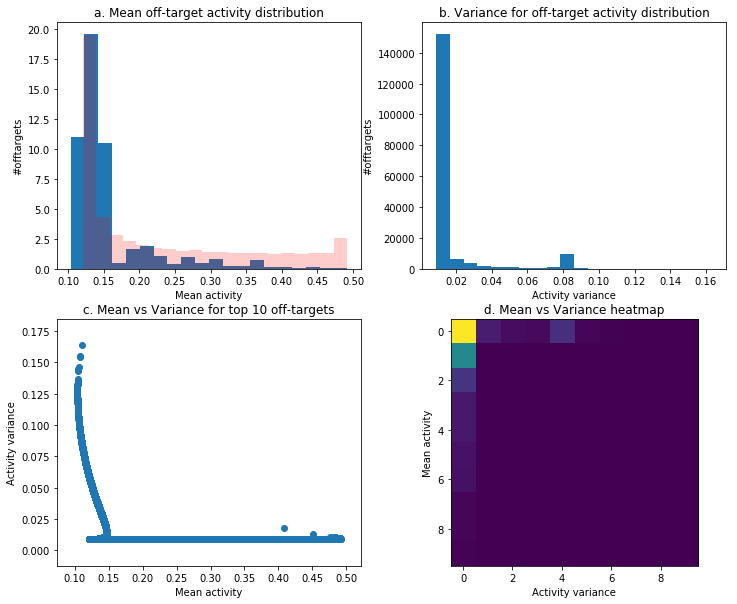

In [94]:
fig, ax = plt.subplots(2, 2)
#fig.suptitle('Off-targets for the best on-target gRNAs')
ax[0][0].hist(total[8].values, density=True, bins=20)
ax[0][0].hist(ko_w_oa, bins=20, density=True, color=(1,0,0,0.2))
ax[0][0].set_title("a. Mean off-target activity distribution")
ax[0][0].set_xlabel("Mean activity")
ax[0][0].set_ylabel("#offtargets")
ax[0][1].hist(total[9].values, bins=20)
#ax[0][1].hist(ko_w_va, bins=20, density=False, color=(1,0,0,0.2))
#ax[0][1].set_ylim((0,100))
ax[0][1].set_title("b. Variance for off-target activity distribution")
ax[0][1].set_xlabel("Activity variance")
ax[0][1].set_ylabel("#offtargets")
ax[1][0].scatter(total[8], total[9])
ax[1][0].set_title("c. Mean vs Variance for top 10 off-targets")
ax[1][0].set_xlabel("Mean activity")
ax[1][0].set_ylabel("Activity variance")
ax[1][1].imshow(pd.crosstab(total[10], total[11]).values)
ax[1][1].set_title("d. Mean vs Variance heatmap")
ax[1][1].set_xlabel("Activity variance")
ax[1][1].set_ylabel("Mean activity")
fig.show()

In [57]:
onehot([1,2,3])

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [89]:
len(pop[0])

46

In [94]:
u = correct_order(onehot(pop[0][0:23]))

In [96]:
u.shape

(92,)

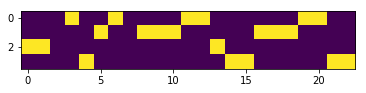

In [98]:
plt.imshow(u.reshape(4, 23))

In [101]:
np.stack([u.reshape(4, 23),u.reshape(4, 23)]).shape

(2, 4, 23)

In [91]:
len(pop[0][23:])

23

In [201]:
def active_and_uncertain(x):
    first = correct_order(onehot(x[0:23])).reshape(4, 23)
    second = correct_order(onehot(x[23:])).reshape(4, 23)
    x = torch.from_numpy(np.stack([first,second])).type(torch.FloatTensor)
    I = x.reshape(1, 2, 4, 23).cuda()
    tb_w = w_model(I)
    mlik = w_model.likelihood(
        tb_w[0]
    )
    tb_w_o = mlik.mean.mean(0).cpu().data.numpy()
    tb_w_v = mlik.variance.mean(0).cpu().data.numpy()**0.5
    mm = sum([int(d==e) for d,e in zip(x[0:23],x[23:])])/23
    return(tb_w_o+0.5*tb_w_v+mm)

In [202]:
from deap import algorithms

In [203]:
import random
from deap import base, creator, tools, algorithms

def evaluate(individual):
    return(active_and_uncertain(individual))

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("nucleotide", random.randint, 1, 4)
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, 
    toolbox.nucleotide, 2*23
)
toolbox.register(
    "population", tools.initRepeat, list, toolbox.individual
)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=4, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [204]:
pop = toolbox.population(n=3000)
hof = tools.HallOfFame(100)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [205]:
pop, log = algorithms.eaSimple(
    pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
    stats=stats, halloffame=hof, verbose=True
)

KeyboardInterrupt: 

In [169]:
np.array(pop)[0]

array([4, 2, 2, 1, 2, 4, 4, 4, 4, 4, 4, 1, 1, 2, 2, 3, 4, 4, 4, 1, 2, 2,
       2, 1, 1, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 4, 1, 2, 3, 3, 3,
       4, 4])

In [170]:
first_t = correct_order(onehot(hof[0][0:23])).reshape(4,23)
second_t = correct_order(onehot(hof[0][23:])).reshape(4,23)

In [148]:
def from_oh(x):
    onehot2nucleotide = {
        1: "A", 2: "T", 3: "G", 4: "C"
    }
    return("".join([onehot2nucleotide[a] for a in x]))

In [149]:
len(hof)

100

In [191]:
def n_mms(a):
    b = a[0:23]
    c = a[23:]
    return(sum([int(d==e) for d,e in zip(b,c)]))

In [174]:
np.unique([n_mms(a) for a in pop], return_counts=True)

(array([18, 19, 20, 21, 22, 23]), array([   1,    7,   35,  187, 2732,   38]))

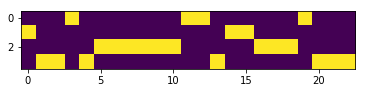

In [175]:
plt.imshow(first_t)

In [177]:
np.stack([first_t, second_t])

(2, 4, 23)

In [180]:
w_f = w_model(
    torch.from_numpy(np.stack([first_t, second_t]).reshape(1, 2, 4, 23)).cuda()
)

In [193]:
n_mms(hof[0])/23

0.043478260869565216

In [197]:
w_o = w_model.likelihood(w_f[0]).mean.mean(0).cpu().data.numpy()
w_v = w_model.likelihood(w_f[0]).variance.mean(0).cpu().data.numpy()**0.5

In [198]:
w_v

array([0.47571176], dtype=float32)

In [199]:
w_v+w_o+n_mms(hof[0])/23

array([0.7504903], dtype=float32)

In [200]:
w_o

array([0.23130026], dtype=float32)

In [171]:
from_oh(hof[0][0:23]), from_oh(hof[0][23:])

('GTTATCCCCCCAATGGCCCATTT', 'AAGGTGGAGGGGCGCAATGGGCC')

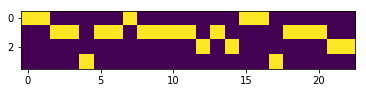

In [173]:
plt.imshow(second_t)